### Given an embedding of SIFT descriptors and their corresponding metadata, perform downstream analysis

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import tiffile as tiff
import glob
import re
import random
import itertools
import anndata as ad
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

random.seed(0)
np.random.seed(0)

In [ ]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

In [3]:
# load the anndata file with the SIFT descriptors
adata = ad.read_h5ad('/gladstone/engelhardt/lab/adamw/saft_figuren/analysis/adata_20250225_kmeans.h5ad')

# the number of rows when first loading the data represents the number of SIFT descriptors used for clustering
num_rows_cluster = adata.obs.shape[0]

adata

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3389740 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10'
    uns: 'kmeans_10', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9'
    obsm: 'X_pca'

In [4]:
# plot the shape of the PCA embeddings after dropping NaN values
adata.obsm['X_pca'][:, 0]

array([-0.74040007,  8.6010379 ,  3.66278238, ..., -1.32592509,
        5.49960101,  7.28865299])

In [5]:
# move PC1 and PC2 from adata.obsm['X_pca'] to adata.obs['PC1'] and adata.obs['PC2']
adata.obs['PC1'] = adata.obsm['X_pca'][:, 0]
adata.obs['PC2'] = adata.obsm['X_pca'][:, 1]

In [6]:
# compute a replicate_id integer based on the well_id
# if the well_id ends in an odd number, then the replicate_id is 1
# if the well_id ends in an even number, then the replicate_id is 0
adata.obs['replicate_id'] = adata.obs['well_id'].apply(lambda x: int(x[-1]) % 2)

In [7]:
# subset the entire adata object to just 50k randomly sampled rows
# this should help with runtime issues and overpowered statistical testing
num_rows = 50000
adata = adata[np.random.choice(adata.shape[0], num_rows, replace=False), :]
adata

View of AnnData object with n_obs × n_vars = 50000 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10', 'PC1', 'PC2', 'replicate_id'
    uns: 'kmeans_10', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9'
    obsm: 'X_pca'

In [8]:
adata.obs.head()

,donor_id,time,well_id,rasa2ko_titration,et_ratio,entropy,p_areas,filename,scales,octaves,...,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10,PC1,PC2,replicate_id
1269,3,61,F5,50.0,1.4142,4.049472,82657,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,2,0,...,1,0,4,5,6,3,0,-4.136739,5.634490,1
1405,2,65,D2,100.0,2.0000,3.704826,86717,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,1,0,...,2,2,2,4,4,5,1,-2.804754,-2.371525,0
1105,3,26,J4,50.0,0.7071,4.404640,97741,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,1,0,...,1,0,4,5,6,3,0,-0.648392,5.092073,0
873,3,46,H4,50.0,1.0000,4.169801,77859,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,1,0,...,2,1,1,6,4,5,1,-1.257959,-3.757435,0
10,3,54,F10,6.3,1.4142,4.234559,123534,/gladstone/engelhardt/lab/MarsonLabIncucyteDat...,2,0,...,0,4,3,3,5,4,2,8.420753,-4.997797,0


### Investigate clustering results

Compute silhouette scores for just a subset of the overall dataset since silhouette is O(n^2) in time complexity. Note that the k-means clustering was performed on the entire adata object prior to downsampling to `num_rows` points.

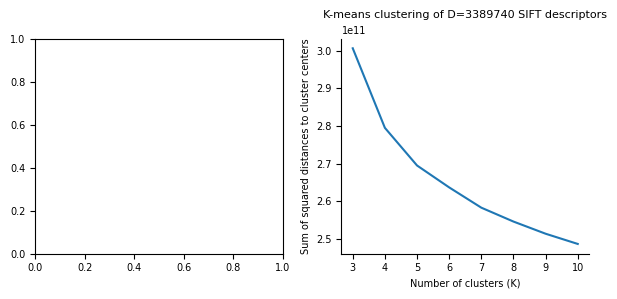

In [9]:
# k-means clustering of SIFT descriptors
k_values = np.arange(3, 11)

# # compute the silhouette score for each value of k on adata
# silhouettes = []
# for k in k_values:
#     colname = 'kmeans_{}'.format(k)
#     # make sure that the clustering results are in category format
#     adata.obs[colname] = adata.obs[colname].astype('category')
#     score = silhouette_score(adata.X, adata.obs[colname])
#     silhouettes.append(score)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
ax = ax.flatten()

# # plot the silhouette score for each value of k on adata_B4_donor1
# ax[0].plot(k_values, silhouettes)
# ax[0].set_xlabel('Number of clusters (k)')
# ax[0].set_ylabel('Silhouette score')
# ax[0].set_title('K-means clustering of D={} SIFT descriptors'.format(num_rows_cluster))
# sns.despine(ax=ax[0])

# plot the wccs score from adata.uns['kmeans_{k}] for each value of k on the entire dataset
wccs = [ adata.uns['kmeans_{}'.format(k)]['wccs'] for k in k_values ]
ax[1].plot(k_values, wccs)
ax[1].set_xlabel('Number of clusters (K)')
ax[1].set_ylabel('Sum of squared distances to cluster centers')
ax[1].set_title('K-means clustering of D={} SIFT descriptors'.format(num_rows_cluster))
sns.despine(ax=ax[1])

plt.show()

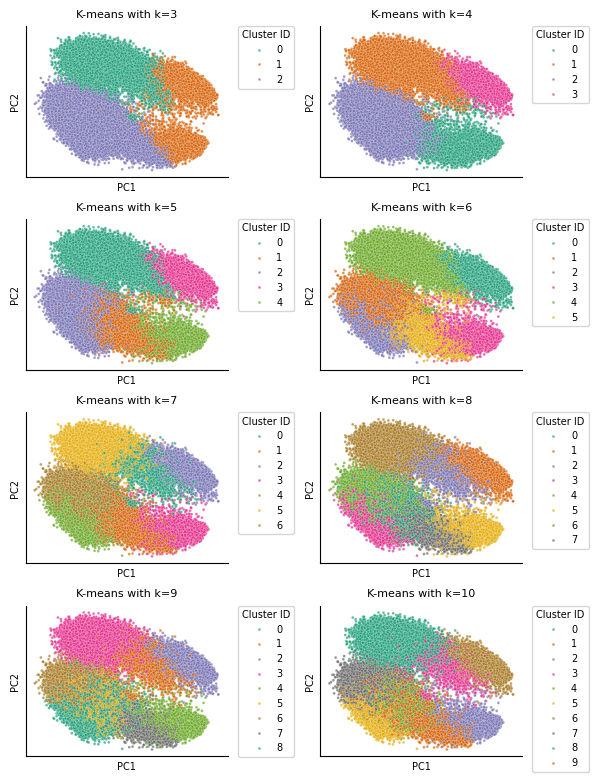

In [10]:
# show the PCA embeddings colored by K-means cluster
fig, ax = plt.subplots(4, 2, figsize=(6, 8), tight_layout=True)
ax = ax.flatten()

for i, k in enumerate(k_values[:8]):
    sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='kmeans_{}'.format(k), palette='Dark2', alpha=0.7, s=4, ax=ax[i])
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    sns.despine(ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('K-means with k={}'.format(k))
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Cluster ID')

plt.show()

Despite the silhouette score being highest for `k=4` clusters, we chose to move forward with `k=7` clusters for downstream analysis as this gave us additional granularity for explaining variation in SIFT descriptors.

### Show the clustering results alongside ROIs for representative descriptors

This will help us qualitatively describe the meaning of each cluster

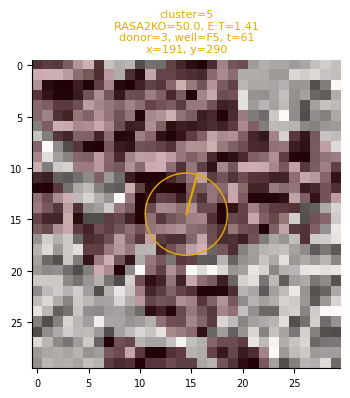

In [80]:
def plot_descriptor_roi(row, ax, offset=None, cluster_col='kmeans_7', add_rfp_mask=False):
    '''
    Plot the SIFT descriptors for a single ROI. Input is a single row of the adata.obs dataframe that contains the columns: filename, x, y,
    '''
    image = tiff.imread(row['filename'])
    # normalize the intensity of the image to range [0, 1]
    image = (image - image.min()) / (image.max() - image.min())

    # compute the radius for this SIFT descriptor
    radius = row['scales'] * (2 ** (row['octaves'] + 1))

    # only show the true ROI if offset is None, otherwise show the ROI with the specified offset
    if offset is None:
        offset = radius
    
    # crop the image to the ROI
    xmin, xmax = row['x'] - offset, row['x'] + offset
    ymin, ymax = row['y'] - offset, row['y'] + offset
    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0
    if xmax > image.shape[0]:
        xmax = image.shape[0]
    if ymax > image.shape[1]:
        ymax = image.shape[1]
    image = image[xmin:xmax, ymin:ymax]

    # optional argument to load the red channel where RFP is expressed in cancer cells
    if add_rfp_mask:
        rfp_filename = row['filename'].replace('phase_registered', 'red_registered')
        rfp_image = tiff.imread(rfp_filename)

        # # normalize the entire image intensity values to range [0, 1]
        # rfp_image = (rfp_image - rfp_image.min()) / (rfp_image.max() - rfp_image.min())

        rfp_image = rfp_image[xmin:xmax, ymin:ymax]
        # threshold the RFP channel into a binary mask
        rfp_mask = rfp_image > 3.5
        ax.imshow(rfp_mask, cmap='Reds', alpha=1.0, vmin=0, vmax=1)
        phase_alpha = 0.7
    else:
        phase_alpha = 1.0
    
    # plot the greyscale image
    ax.imshow(image, cmap='gray', alpha=phase_alpha, vmin=0, vmax=1)

    # find the center point of the image.shape matrix
    height, width = image.shape
    x = (width - 1) / 2.0
    y = (height - 1) / 2.0
    
    # set color of title and circle based on the cluster_col value and the Dark2 colormap
    color = cm.Dark2(row[cluster_col])
    # annotate the ROI with a circle that has r=radius
    circle = patches.Circle((x, y), radius, edgecolor=color, facecolor='none')
    ax.add_patch(circle)

    # add a line going from the center of the circle to the perimeter of the circle and an angle of row['orientations']
    angle = row['orientations']
    ax.plot([x, x + radius * np.cos(angle)], [y, y + radius * np.sin(angle)], color=color)


    sns.despine(ax=ax)
    ax.set_title('cluster={}\nRASA2KO={}, E:T={}\ndonor={}, well={}, t={}\nx={}, y={}'.format(row[cluster_col], round(row['rasa2ko_titration'], 2), round(row['et_ratio'], 2), row['donor_id'], row['well_id'], row['time'], row['x'], row['y']),)
    # set color of the title based on the cluster_col value and the Dark2 colormap
    ax.title.set_color(color)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
plot_descriptor_roi(adata.obs.iloc[0], ax, offset=15, add_rfp_mask=True)

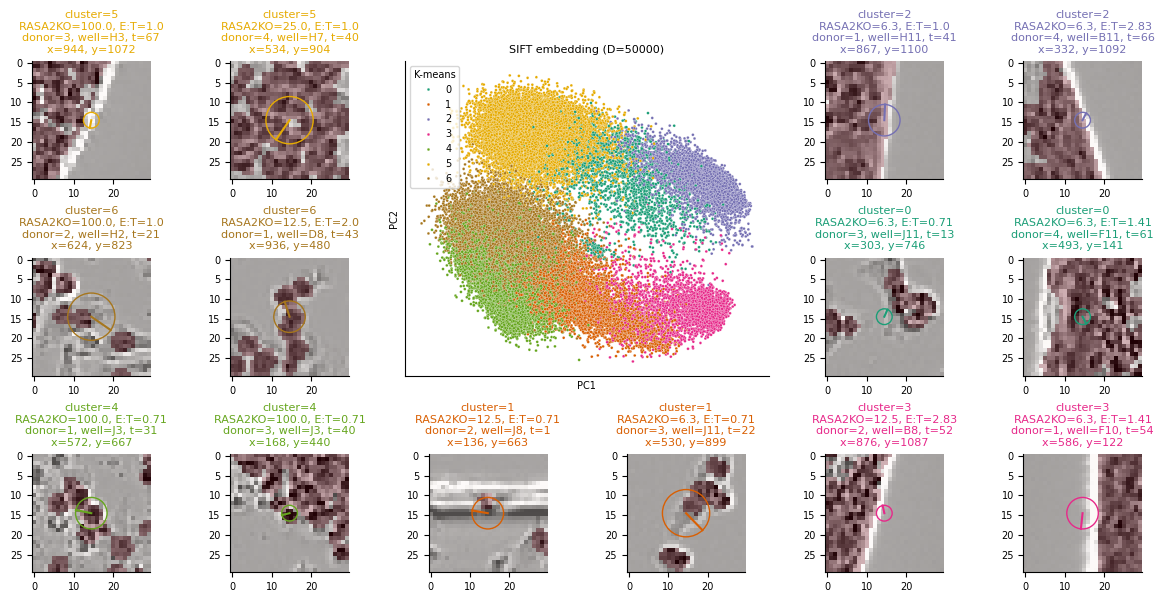

In [82]:
# create a 7x3 grid of subplots where the middle 3 rows and columns are merged into one 3x3 subplot 
fig, ax = plt.subplots(3, 6, figsize=(12, 6), tight_layout=True)
# merge the middle 3 rows and columns into one 3x3 subplot
gs = ax[0, 2].get_gridspec()
for i in range(0, 2):
    for j in range(2, 4):
        ax[i, j].remove()

# plot the PCA embedding for donor_id==1 and well_id==B4 in the big center subplot
axbig = fig.add_subplot(gs[0:2, 2:4])
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='kmeans_7', palette='Dark2', alpha=1, s=4, ax=axbig)
axbig.set_title('SIFT embedding (D={})'.format(num_rows))
# axbig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='K-means k=7')
axbig.legend(title='K-means')
sns.despine(ax=axbig)
axbig.set_xticks([])
axbig.set_yticks([])


def plot_two_random_rois(adata, cluster_id, ax1, ax2, cluster_col='kmeans_7', offset=15, add_rfp_mask=False):
    ''' Plot two random ROIs belonging to the cluster_col==cluster_id '''
    temp_df = adata.obs[adata.obs[cluster_col]==cluster_id]
    temp_df = temp_df.iloc[np.random.choice(temp_df.shape[0], 2, replace=False), :]
    plot_descriptor_roi(temp_df.iloc[0], ax1, offset=offset, add_rfp_mask=add_rfp_mask)
    plot_descriptor_roi(temp_df.iloc[1], ax2, offset=offset, add_rfp_mask=add_rfp_mask)

# plot ROIs on the left and right of the big center subplot
plot_two_random_rois(adata, 5, ax[0, 0], ax[0, 1], add_rfp_mask=True)
plot_two_random_rois(adata, 6, ax[1, 0], ax[1, 1], add_rfp_mask=True)
plot_two_random_rois(adata, 4, ax[2, 0], ax[2, 1], add_rfp_mask=True)
plot_two_random_rois(adata, 2, ax[0, 4], ax[0, 5], add_rfp_mask=True)
plot_two_random_rois(adata, 0, ax[1, 4], ax[1, 5], add_rfp_mask=True)
plot_two_random_rois(adata, 3, ax[2, 4], ax[2, 5], add_rfp_mask=True)
plot_two_random_rois(adata, 1, ax[2, 2], ax[2, 3], add_rfp_mask=True)


plt.show()

### TODO: add figures + analysis that quantitatively describes the images belonging to each cluster

This can include texture analysis, looking at ocataves, and RFP intensity.

In [13]:
# use the xy-coordinates of each SIFT descriptor to find its radius (in pixels) away from the center of the image
# start by shifting x and y coordinates to be centered at 0,0
adata.obs['x_centered'] = adata.obs['x'] - adata.obs['x'].mean()
adata.obs['y_centered'] = adata.obs['y'] - adata.obs['y'].mean()
# compute the radius of each SIFT descriptor
adata.obs['radius_from_center'] = np.sqrt(adata.obs['x_centered']**2 + adata.obs['y_centered']**2)
adata.obs['radius_from_center'].describe()

# compute square root of the radius_from_center values
adata.obs['sqrt_radius_from_center'] = np.sqrt(adata.obs['radius_from_center']) / adata.obs['radius_from_center'].max()

/tmp/ipykernel_2377863/2626283965.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['x_centered'] = adata.obs['x'] - adata.obs['x'].mean()
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
# compute the standard deviation in the radius_from_center values within each kmeans_7 cluster
cluster_radii_df = []
for k, group in adata.obs.groupby('kmeans_7'):
    
    sqrt_mean = group['sqrt_radius_from_center'].mean()
    sqrt_stdev = group['sqrt_radius_from_center'].std()

    mean = group['radius_from_center'].mean()
    stdev = group['radius_from_center'].std()
    cluster_radii_df.append(pd.DataFrame({'kmeans_7': [k], 
                                          'radius_from_center_mean': [mean],
                                          'radius_from_center_stdev': [stdev],
                                          'sqrt_radius_from_center_mean': [sqrt_mean],
                                          'sqrt_radius_from_center_stdev': [sqrt_stdev]}))
cluster_radii_df = pd.concat(cluster_radii_df)
cluster_radii_df

/tmp/ipykernel_2377863/3544044636.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for k, group in adata.obs.groupby('kmeans_7'):


,kmeans_7,radius_from_center_mean,radius_from_center_stdev,sqrt_radius_from_center_mean,sqrt_radius_from_center_stdev
0,0,443.331213,105.799357,0.034555,0.004939
0,1,384.738122,140.509623,0.031795,0.006820
0,2,530.797486,37.050528,0.038165,0.001515
0,3,524.271944,36.889634,0.037931,0.001473
0,4,316.647067,136.425576,0.028661,0.006988
0,5,364.061252,137.346090,0.030909,0.006726
0,6,321.356964,141.601395,0.028844,0.007157


/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


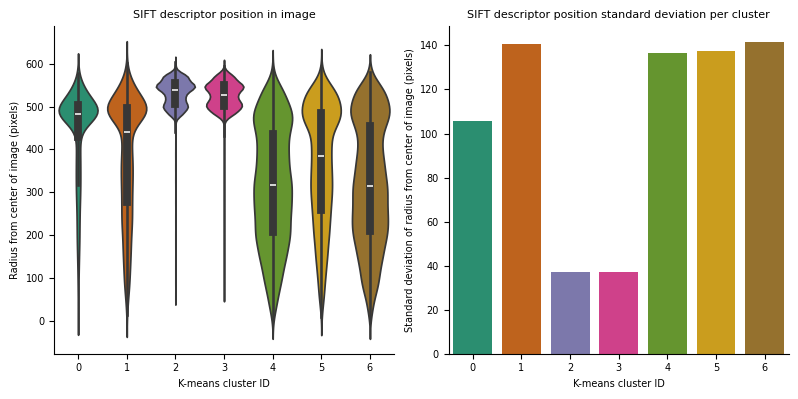

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


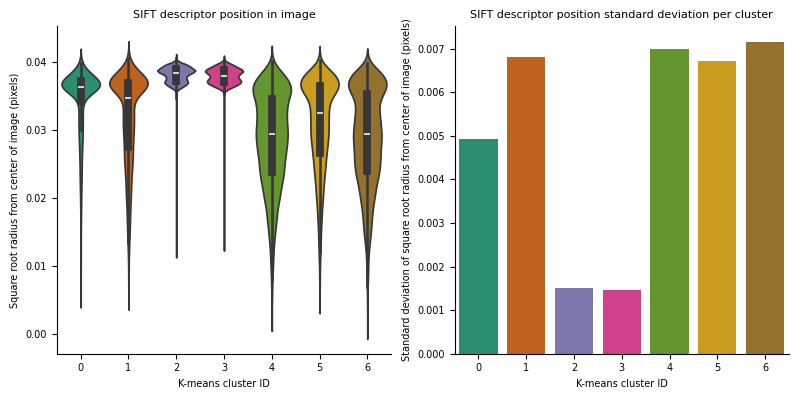

In [15]:
# plot the SIFT descriptor radii from image centers for each kmeans_7 cluster
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax = ax.flatten()

# violin plot of the radius from center of each SIFT descriptor
sns.violinplot(ax=ax[0], data=adata.obs, x='kmeans_7', y='radius_from_center', hue='kmeans_7', legend=False, palette='Dark2')
ax[0].set_title('SIFT descriptor position in image')
ax[0].set_xlabel('K-means cluster ID')
ax[0].set_ylabel('Radius from center of image (pixels)')
sns.despine(ax=ax[0])

# bar plot of the variance of the radius from center
sns.barplot(ax=ax[1], data=cluster_radii_df, x='kmeans_7', y='radius_from_center_stdev', hue='kmeans_7', legend=False, palette='Dark2')
ax[1].set_title('SIFT descriptor position standard deviation per cluster')
ax[1].set_xlabel('K-means cluster ID')
ax[1].set_ylabel('Standard deviation of radius from center of image (pixels)')
sns.despine(ax=ax[1])
plt.show()

# plot the square root of the radius from center of each SIFT descriptor
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax = ax.flatten()

# violin plot of the radius from center of each SIFT descriptor
sns.violinplot(ax=ax[0], data=adata.obs, x='kmeans_7', y='sqrt_radius_from_center', hue='kmeans_7', legend=False, palette='Dark2')
ax[0].set_title('SIFT descriptor position in image')
ax[0].set_xlabel('K-means cluster ID')
ax[0].set_ylabel('Square root radius from center of image (pixels)')
sns.despine(ax=ax[0])

# bar plot of the variance of the radius from center
sns.barplot(ax=ax[1], data=cluster_radii_df, x='kmeans_7', y='sqrt_radius_from_center_stdev', hue='kmeans_7', legend=False, palette='Dark2')
ax[1].set_title('SIFT descriptor position standard deviation per cluster')
ax[1].set_xlabel('K-means cluster ID')
ax[1].set_ylabel('Standard deviation of square root radius from center of image (pixels)')
sns.despine(ax=ax[1])
plt.show()

In [16]:
# compute the ROI radius for each SIFT descriptor
adata.obs['roi_radius'] = adata.obs['scales'] * (2 ** (adata.obs['octaves'] + 1))
adata.obs['roi_radius'].value_counts()

roi_radius
2      27057
4      15670
6       6266
8        684
12       212
384       64
16        26
24        13
256        8
Name: count, dtype: int64

In [17]:
adata.obs['octaves'].value_counts()

octaves
0    46916
1     2896
2      116
6       72
Name: count, dtype: int64

In [18]:
adata.obs['scales'].value_counts()

scales
1    29211
2    14234
3     6555
Name: count, dtype: int64

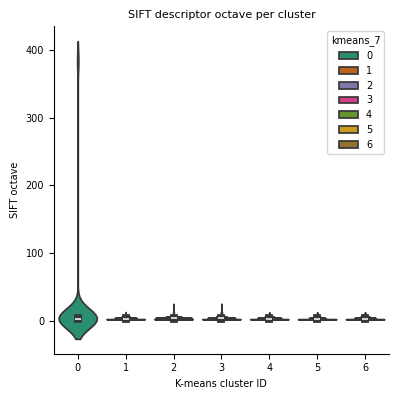

In [19]:
# plot a swarmplot of SIFT octaves from each cluster
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)

sns.violinplot(ax=ax, data=adata.obs, x='kmeans_7', y='roi_radius', hue='kmeans_7', palette='Dark2')
ax.set_title('SIFT descriptor octave per cluster')
ax.set_xlabel('K-means cluster ID')
ax.set_ylabel('SIFT octave')
sns.despine(ax=ax)

plt.show()

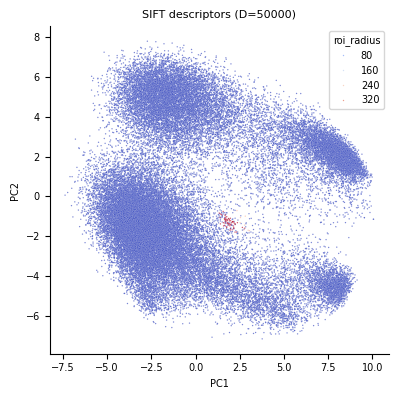

In [20]:
# plot the PCA embedding annotated by roi_radius
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='roi_radius', palette='coolwarm', ax=ax, s=1, alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SIFT descriptors (D={})'.format(num_rows))
sns.despine(ax=ax)
plt.show()

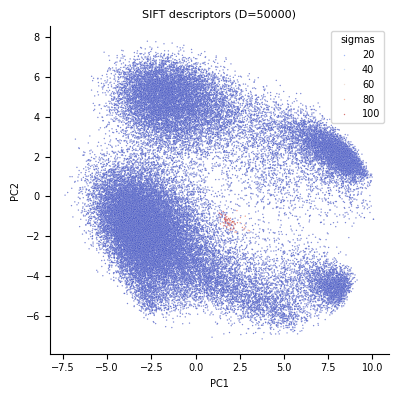

In [66]:
# plot the PCA embedding annotated by sigmas (the gaussian blur)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='sigmas', palette='coolwarm', ax=ax, s=1, alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SIFT descriptors (D={})'.format(num_rows))
sns.despine(ax=ax)
plt.show()

In [32]:
adata.obs.columns

Index(['donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio',
       'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas',
       'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4',
       'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10',
       'PC1', 'PC2', 'replicate_id', 'x_centered', 'y_centered',
       'radius_from_center', 'sqrt_radius_from_center', 'roi_radius'],
      dtype='object')

In [36]:
adata.obs[['scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'kmeans_7', 'donor_id', 'time', 'well_id']].sort_values(['donor_id', 'time', 'well_id']).head()

,scales,octaves,sigmas,orientations,x,y,kmeans_7,donor_id,time,well_id
98,2,0,1.201556,0.191926,135,539,0,1,0,B2
695,2,0,1.403137,-1.202717,882,142,3,1,0,B2
620,1,0,1.018904,1.285804,904,763,4,1,0,B3
853,1,0,1.035888,2.482440,137,764,4,1,0,B3
119,1,0,0.989062,-2.594003,166,908,4,1,0,B3


### Look at RFP intensity values near each SIFT descriptor

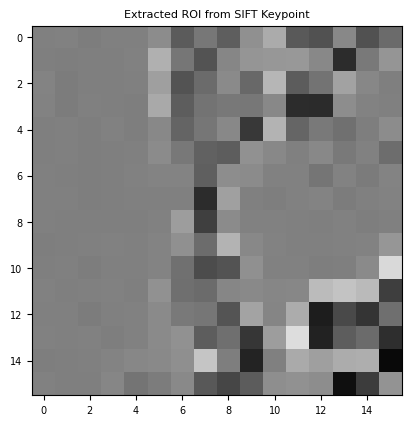

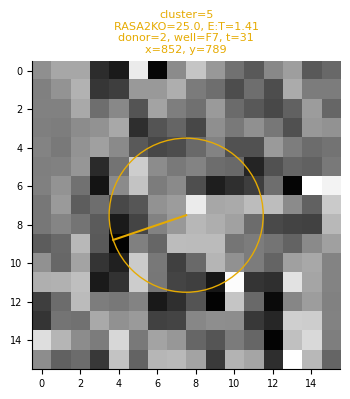

In [93]:
import numpy as np
from skimage.transform import warp
import matplotlib.pyplot as plt

def extract_sift_roi(image, keypoint, orientation, scale, patch_size=16):
    """
    Extract a square ROI patch from the image centered at the keypoint,
    rotated by the given orientation and scaled by the given scale factor.
    
    Parameters:
      image : 2D array (grayscale image)
      keypoint : (row, col) coordinate of the SIFT keypoint
      orientation : orientation in radians (measured from the x-axis)
      scale : scale factor associated with the keypoint (i.e. relative size)
      patch_size : size of the output patch (default is 16, as used in SIFT)
    
    Returns:
      patch : extracted patch as a 2D array of shape (patch_size, patch_size)
    """
    theta = orientation  # angle in radians

    def mapping(coords):
        """
        Maps coordinates in the output (patch) image to coordinates in the input image.
        'coords' is an (N, 2) array of (row, col) pixel coordinates in the patch.
        """
        # Shift patch coordinates so that the center is (patch_size/2, patch_size/2)
        centered = coords - (patch_size / 2)
        # Create the rotation matrix (note: using (row, col) convention)
        rot = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]])
        # Scale and rotate the centered coordinates.
        # Each output pixel corresponds to 'scale' pixels in the input image.
        transformed = scale * np.dot(centered, rot.T)
        # Shift by the keypoint location (which is in (row, col) order)
        return transformed + keypoint

    # The warp function applies the inverse mapping to sample the patch.
    patch = warp(image, inverse_map=mapping, output_shape=(patch_size, patch_size))
    return patch

# ---------------------
# Example usage:
# ---------------------
# Suppose you have already computed the SIFT properties:
# descriptor_extractor.detect_and_extract(phase_frame)
# keypoints1, orientations1, scales1 = descriptor_extractor.keypoints, descriptor_extractor.orientations, descriptor_extractor.scales


def extract_sift_roi_from_adata(row):
    # load the image using the filename
    img = tiff.imread(row['filename'])
    # normalize intensity of the image to the range [0, 1]
    img = (img - img.min()) / (img.max() - img.min())

    kp = (row['x'], row['y'])

    return extract_sift_roi(img, kp, row['orientations'], row['scales'])

row = adata.obs.iloc[8]
temp_roi = extract_sift_roi_from_adata(row)
# Visualize the first extracted patch
plt.imshow(temp_roi, cmap='gray', vmin=0, vmax=1)
plt.title('Extracted ROI from SIFT Keypoint')
# plt.axis('off')
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
plot_descriptor_roi(row, ax, offset=8, add_rfp_mask=False)
plt.show()

In [75]:
temp_roi.min(), temp_roi.max()

(125.980484, 164.27956)

In [69]:
adata.obs.iloc[0]

donor_id                                                                   3
time                                                                      61
well_id                                                                   F5
rasa2ko_titration                                                       50.0
et_ratio                                                              1.4142
entropy                                                             4.049472
p_areas                                                                82657
filename                   /gladstone/engelhardt/lab/MarsonLabIncucyteDat...
scales                                                                     2
octaves                                                                    0
sigmas                                                              1.274167
orientations                                                       -1.303474
x                                                                        191

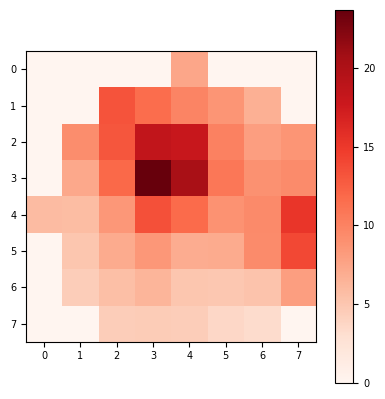

In [65]:
import cv2

def fetch_roi_rfp_channel(row):
    """
    Fetch the RFP channel image for a given row of the adata.obs dataframe
    """
    # find the RFP channel image for this ROI
    filename = row['filename'].replace('phase_registered', 'red_registered')
    image = tiff.imread(filename)

    # compute the radius for this SIFT descriptor
    radius = row['scales'] * (2 ** (row['octaves'] + 1))

    # crop the image to the ROI
    offset = radius
    xmin, xmax = row['x'] - offset, row['x'] + offset
    ymin, ymax = row['y'] - offset, row['y'] + offset
    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0
    if xmax > image.shape[0]:
        xmax = image.shape[0]
    if ymax > image.shape[1]:
        ymax = image.shape[1]
    image = image[xmin:xmax, ymin:ymax]

    # create a circle mask for the ROI where all values inside the circle are 1, and the rest are 0
    roi_mask = np.zeros(image.shape)
    roi_mask = cv2.circle(roi_mask, (radius, radius), radius, 1, -1)

    # apply the ROI mask to the RFP image
    rfp_image = image * roi_mask

    return rfp_image


fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
temp_rfp_img = fetch_roi_rfp_channel(adata.obs.iloc[0])
im = ax.imshow(temp_rfp_img, cmap='Reds')
cbar = fig.colorbar(im, ax=ax)
plt.show()

In [68]:
np.min(temp_rfp_img)

0.0

### Show the `k=7` clustering results alongside the other covariates

This figure will accompany the statistical testing to show which clusters are enriched or depleted in certain experimental conditions. We expect there to be very minimal effect of donor and replicate (i.e. they are the negative controls) but there should be some effects over ratio, titration, and time.

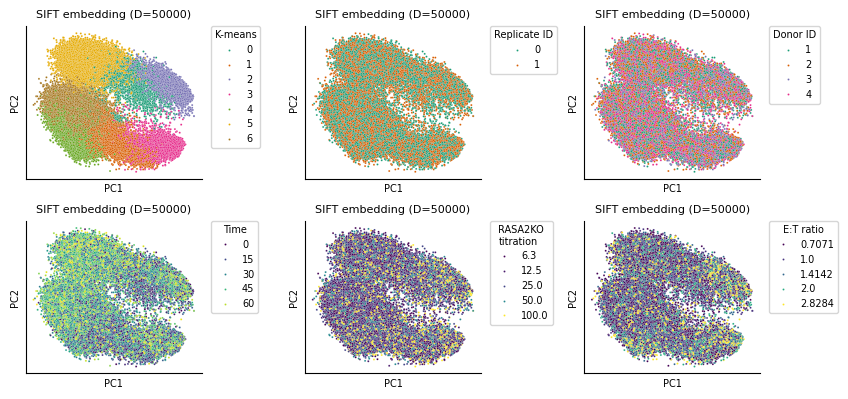

In [21]:
# create a matrix of SIFT PCA embeddings, annotating the points by donor_id, time, rasa2ko_titration, et_ratio
fig, ax = plt.subplots(2, 3, figsize=(8.5, 4), tight_layout=True)
ax = ax.flatten()

hue_cols = ['kmeans_7', 'replicate_id', 'donor_id', 'time', 'rasa2ko_titration', 'et_ratio']
hue_titles = ['K-means', 'Replicate ID', 'Donor ID', 'Time', 'RASA2KO\ntitration', 'E:T ratio']
cmaps = ['Dark2', 'Dark2', 'Dark2', 'viridis', 'viridis', 'viridis']
for i, hue in enumerate(hue_cols):
    # randomize the order of adata.obs so that one color isn't consistently plotted on top of another
    # plot_data = adata.obs.sample(frac=1)
    sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue=hue, palette=cmaps[i], ax=ax[i], legend=True, alpha=1, s=2)
    ax[i].set_title('SIFT embedding (D={})'.format(num_rows))
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    sns.despine(ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_titles[i])


plt.show()

## Statistical testing

Perform a series of statistical tests to determine whether certatin clusters are enriched or depleted for their number of SIFT descriptors (i.e. rows in the dataframe) against a series of covariates `'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio'`.

A brief explanation is provided below each code block of statistical testing as the methods for generating the p-values and effect sizes vary between statistical test.

In [22]:


# Assume df is your dataframe
# Columns: ['et_ratio', 'rasa2ko_titration', 'time', 'donor_id', 'well_id', 'kmeans_7']
df = adata.obs

# # Option: Downsample your data to reduce overpowered tests
# subsample_size = 10000  # adjust as needed
# df = df.sample(n=subsample_size)

# Store p-values
p_values = {}

# 1. ANOVA for Continuous Variables (et_ratio, rasa2ko_titration, time)
continuous_vars = ['et_ratio', 'rasa2ko_titration', 'time']
for var in continuous_vars:
    model = ols(f"{var} ~ C(kmeans_7)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA
    p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value

# 2. Chi-square Test for Categorical Variables (donor_id, well_id)
categorical_vars = ['donor_id', 'replicate_id']
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df["kmeans_7"])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_values[var] = p

# 3. Multiple Testing Correction (FDR using Benjamini-Hochberg)
p_vals_corrected = multipletests(list(p_values.values()), method='fdr_bh')[1]

# Create a results DataFrame
results = pd.DataFrame({'var_name': p_values.keys(), 'p_val': p_values.values(), 'p_adj': p_vals_corrected})

# Sort results by adjusted p-value
results = results.sort_values(by='p_adj')

results

/tmp/ipykernel_2377863/3945854203.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value
/tmp/ipykernel_2377863/3945854203.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value
/tmp/ipykernel_2377863/3945854203.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-v

,var_name,p_val,p_adj
0,et_ratio,0.000000e+00,0.000000e+00
2,time,0.000000e+00,0.000000e+00
1,rasa2ko_titration,6.062777e-154,1.010463e-153
3,donor_id,2.417010e-98,3.021263e-98
4,replicate_id,1.701166e-06,1.701166e-06


#### Explanation:
1. ANOVA: Tests whether the mean of continuous variables (ratio, titration, time) significantly differs between clusters.
2. Chi-square Test: Checks if categorical variables (donor, well_id) are distributed differently across clusters.
3. FDR Correction: Uses the Benjamini-Hochberg method to control for false discovery rate (instead of Bonferroni, which is more conservative).

This will give you a table of p-values and adjusted p-values, helping you determine which covariates are significantly associated with cluster membership.

In [23]:
df = adata.obs

# # Option: Downsample your data to reduce overpowered tests
# df = df.sample(n=subsample_size)

# Assume df is your DataFrame with 'kmeans_7' and other variables
continuous_vars = ['time']
categorical_vars = ['donor_id', 'replicate_id', 'et_ratio', 'rasa2ko_titration']
results = []

### Function to compute Cohen's d (standardized effect size)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x**2 + (ny - 1) * std_y**2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std if pooled_std > 0 else 0

# Iterate over each cluster
for cluster in df["kmeans_7"].unique():
    cluster_mask = df["kmeans_7"] == cluster

    # 1. Kruskal-Wallis Test for Continuous Variables
    for var in continuous_vars:
        cluster_values = df.loc[cluster_mask, var]
        other_values = df.loc[~cluster_mask, var]

        if len(cluster_values) > 1 and len(other_values) > 1:  # Ensure enough data points
            stat, p_val = stats.kruskal(cluster_values, other_values)
            effect_size = cohens_d(cluster_values, other_values)  # Cohen's d

            results.append([cluster, var, None, p_val, effect_size, 'kruskal', 'cohens_d'])  # 'var_value' is None

    # 2. Chi-square Test for Categorical Variables
    for var in categorical_vars:
        for val in df[var].unique():
            in_cluster = sum((df[var] == val) & cluster_mask)
            out_cluster = sum((df[var] == val) & ~cluster_mask)
            not_in_cluster = sum(cluster_mask) - in_cluster
            not_out_cluster = sum(~cluster_mask) - out_cluster
            contingency_table = np.array([[in_cluster, not_in_cluster],
                                          [out_cluster, not_out_cluster]])

            if contingency_table.min() < 5:
                test_name = 'fisher'
                oddsratio, p_val = stats.fisher_exact(contingency_table)
            else:
                test_name = 'chi2'
                chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
                oddsratio = (in_cluster * not_out_cluster) / max((out_cluster * not_in_cluster), 1)

            effect_size = np.log2(oddsratio) if oddsratio > 0 else 0  # Log2 odds ratio

            results.append([cluster, var, val, p_val, effect_size, test_name, 'log2_odds'])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['kmeans_7', 'var_name', 'var_value', 'p_val', 'effect_size', 'test_type', 'effect_type'])

# Apply Benjamini-Hochberg FDR correction
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# compute absolute value of effect size
results_df['abs_effect_size'] = np.abs(results_df['effect_size'])

# compute -log10(p_adj)
results_df['-log10(p_adj)'] = -np.log10(results_df['p_adj'])

# Sort results by adjusted p-value for easier interpretation
results_df = results_df.sort_values(by=['-log10(p_adj)', 'abs_effect_size'], ascending=False)

results_df



,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
85,1,time,NaN,9.630257e-232,-0.491847,kruskal,cohens_d,1.146001e-229,0.491847,228.940815
0,5,time,NaN,1.187947e-224,0.357280,kruskal,cohens_d,7.068284e-223,0.357280,222.150686
79,2,et_ratio,2.8284,4.620058e-143,1.190844,chi2,log2_odds,1.832623e-141,1.190844,140.736927
77,2,et_ratio,0.7071,5.751074e-108,-1.080850,chi2,log2_odds,1.710944e-106,1.080850,105.766764
34,6,time,NaN,4.977026e-81,0.213732,kruskal,cohens_d,1.184532e-79,0.213732,78.926453
...,...,...,...,...,...,...,...,...,...,...
108,0,replicate_id,0.0000,8.462088e-01,-0.013899,chi2,log2_odds,8.680935e-01,0.013899,0.061433
107,0,replicate_id,1.0000,8.462088e-01,0.013899,chi2,log2_odds,8.680935e-01,0.013899,0.061433
97,1,rasa2ko_titration,50.0000,8.675333e-01,0.010073,chi2,log2_odds,8.823630e-01,0.010073,0.054353
94,1,et_ratio,0.7071,8.888651e-01,0.007077,chi2,log2_odds,8.963978e-01,0.007077,0.047499


#### Explanation of Code
1. Kruskal-Wallis test is used for continuous variables (`time`, `ratio`, `titration`).
    - Use Kruskal-Wallis (KW) test: Since time may not be normally distributed, KW is a non-parametric alternative to ANOVA that compares medians across clusters.
    - Effect size: Cohen’s d (standardized mean difference).
        - Measures how much the mean time value differs between the cluster and non-cluster points.
        - Positive d = cluster has later times, negative d = cluster has earlier times.
    - `var_value = None` because continuous variables don’t have discrete values like categorical ones.
2. Chi-square or Fisher’s exact test is used for categorical variables (`donor`, `replicate_id`).
    - Iterate through each cluster (kmeans_7) and each variable (ratio, titration, etc.).
    - For each unique value of the variable, create a 2×2 contingency table comparing its presence in the cluster vs. outside it.
    - Perform a statistical test:
        - Fisher’s exact test for small sample sizes (when any cell <5).
        - Chi-square test for larger samples.
    - Compute effect size:
        - Odds ratio measures enrichment/depletion.
        - Log2 transformation makes it more interpretable:
            - Positive = enriched in the cluster
            - Negative = depleted in the cluster
3. Benjamini-Hochberg (FDR) correction is applied to all p-values to control false discovery rate.

#### Interpretation
- Cluster 1 has significantly lower time values (p_adj = 0.005, Cohen’s d = -1.2).
- Cluster 1 is enriched for donor A1 (p_adj = 0.007, log2 odds ratio = 2.5).
- Cluster 2 has significantly higher titration values (p_adj = 0.02).
- Cluster 4 shows no significant association with replicate_id 0 (p_adj = 0.87).

In [24]:
results_df[results_df['p_adj'] < 0.05].var_name.value_counts()

var_name
rasa2ko_titration    23
et_ratio             20
donor_id             17
time                  7
replicate_id          6
Name: count, dtype: int64

In [25]:
results_df[(results_df['var_name'] == 'time')]

,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
85,1,time,NaN,9.630257e-232,-0.491847,kruskal,cohens_d,1.146001e-229,0.491847,228.940815
0,5,time,NaN,1.187947e-224,0.357280,kruskal,cohens_d,7.068284e-223,0.357280,222.150686
34,6,time,NaN,4.977026e-81,0.213732,kruskal,cohens_d,1.184532e-79,0.213732,78.926453
102,0,time,NaN,1.590945e-68,-0.407789,kruskal,cohens_d,2.704607e-67,0.407789,66.567896
17,4,time,NaN,7.403590e-58,-0.190492,kruskal,cohens_d,8.810272e-57,0.190492,56.055011
51,3,time,NaN,3.047594e-05,-0.090697,kruskal,cohens_d,7.555493e-05,0.090697,4.121737
68,2,time,NaN,6.349112e-03,-0.050233,kruskal,cohens_d,1.127678e-02,0.050233,1.947815


In [26]:
results_df[(results_df['var_name'] == 'replicate_id')]

,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
40,6,replicate_id,0.0,0.000002,0.141211,chi2,log2_odds,0.000005,0.141211,5.346292
39,6,replicate_id,1.0,0.000002,-0.141211,chi2,log2_odds,0.000005,0.141211,5.346292
57,3,replicate_id,0.0,0.000646,-0.175648,chi2,log2_odds,0.001302,0.175648,2.885364
56,3,replicate_id,1.0,0.000646,0.175648,chi2,log2_odds,0.001302,0.175648,2.885364
73,2,replicate_id,1.0,0.002782,0.117698,chi2,log2_odds,0.005255,0.117698,2.279396
74,2,replicate_id,0.0,0.002782,-0.117698,chi2,log2_odds,0.005255,0.117698,2.279396
23,4,replicate_id,0.0,0.431798,-0.027004,chi2,log2_odds,0.524326,0.027004,0.280399
22,4,replicate_id,1.0,0.431798,0.027004,chi2,log2_odds,0.524326,0.027004,0.280399
90,1,replicate_id,1.0,0.459296,-0.031602,chi2,log2_odds,0.546563,0.031602,0.262360
91,1,replicate_id,0.0,0.459296,0.031602,chi2,log2_odds,0.546563,0.031602,0.262360


In [27]:
results_df[(results_df['var_name'] == 'donor_id')]

,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
35,6,donor_id,3.0,7.962150e-39,-0.503107,chi2,log2_odds,7.288430e-38,0.503107,37.137366
69,2,donor_id,3.0,1.759663e-32,0.537380,chi2,log2_odds,1.308750e-31,0.537380,30.883143
71,2,donor_id,4.0,4.870678e-28,-0.506994,chi2,log2_odds,3.050582e-27,0.506994,26.515617
37,6,donor_id,4.0,4.762836e-21,0.299416,chi2,log2_odds,2.833888e-20,0.299416,19.547617
52,3,donor_id,3.0,3.618137e-16,0.481692,chi2,log2_odds,1.871993e-15,0.481692,14.727696
2,5,donor_id,2.0,4.553004e-15,0.275328,chi2,log2_odds,2.083875e-14,0.275328,13.681128
1,5,donor_id,3.0,7.809910e-10,-0.247639,chi2,log2_odds,2.904310e-09,0.247639,8.536957
54,3,donor_id,4.0,2.950787e-09,-0.354270,chi2,log2_odds,1.032775e-08,0.354270,7.985994
53,3,donor_id,2.0,2.438086e-04,-0.225178,chi2,log2_odds,5.802645e-04,0.225178,3.236374
86,1,donor_id,3.0,5.035364e-04,0.177339,chi2,log2_odds,1.070015e-03,0.177339,2.970610


In [28]:
results_df[(results_df['var_name'] == 'rasa2ko_titration')]

,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
81,2,rasa2ko_titration,100.0,3.991828e-65,0.822330,chi2,log2_odds,5.278084e-64,0.822330,63.277524
47,6,rasa2ko_titration,100.0,8.987014e-42,-0.606350,chi2,log2_odds,9.722315e-41,0.606350,40.012230
82,2,rasa2ko_titration,6.3,8.744755e-29,-0.568938,chi2,log2_odds,5.781255e-28,0.568938,27.237978
64,3,rasa2ko_titration,100.0,1.627766e-20,0.597679,chi2,log2_odds,9.224005e-20,0.597679,19.035080
80,2,rasa2ko_titration,50.0,3.682660e-18,0.415153,chi2,log2_odds,1.991984e-17,0.415153,16.700714
13,5,rasa2ko_titration,100.0,8.479461e-13,-0.332286,chi2,log2_odds,3.737244e-12,0.332286,11.427449
48,6,rasa2ko_titration,6.3,6.328622e-11,0.224521,chi2,log2_odds,2.689664e-10,0.224521,9.570302
83,2,rasa2ko_titration,25.0,2.094983e-10,-0.320462,chi2,log2_odds,8.310101e-10,0.320462,9.080394
50,6,rasa2ko_titration,12.5,6.995088e-10,0.210052,chi2,log2_odds,2.685211e-09,0.210052,8.571022
46,6,rasa2ko_titration,50.0,1.446947e-09,-0.236845,chi2,log2_odds,5.217778e-09,0.236845,8.282514


In [39]:
results_df[(results_df['var_name'] == 'et_ratio')]

,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
79,2,et_ratio,2.8284,4.620058e-143,1.190844,chi2,log2_odds,1.832623e-141,1.190844,140.736927
77,2,et_ratio,0.7071,5.751074e-108,-1.080850,chi2,log2_odds,1.710944e-106,1.080850,105.766764
43,6,et_ratio,0.7071,4.240894e-77,0.574703,chi2,log2_odds,8.411106e-76,0.574703,75.075147
45,6,et_ratio,2.8284,5.051834e-66,-0.817087,chi2,log2_odds,7.514603e-65,0.817087,64.124094
76,2,et_ratio,2.0000,1.069090e-40,0.661729,chi2,log2_odds,1.060181e-39,0.661729,38.974620
62,3,et_ratio,2.8284,2.600008e-33,0.767266,chi2,log2_odds,2.210007e-32,0.767266,31.655606
42,6,et_ratio,2.0000,1.590107e-32,-0.526680,chi2,log2_odds,1.261485e-31,0.526680,30.899118
60,3,et_ratio,0.7071,3.429252e-31,-0.715914,chi2,log2_odds,2.400476e-30,0.715914,29.619703
59,3,et_ratio,2.0000,5.047705e-16,0.529743,chi2,log2_odds,2.502820e-15,0.529743,14.601570
9,5,et_ratio,0.7071,2.405081e-15,0.264802,chi2,log2_odds,1.144818e-14,0.264802,13.941263


In [55]:
results_df[(results_df['kmeans_7'] == 5)]

,kmeans_7,var_name,var_value,p_val,effect_size,test_type,effect_type,p_adj,abs_effect_size,-log10(p_adj)
0,5,time,NaN,1.187947e-224,0.357280,kruskal,cohens_d,7.068284e-223,0.357280,222.150686
9,5,et_ratio,0.7071,2.405081e-15,0.264802,chi2,log2_odds,1.144818e-14,0.264802,13.941263
2,5,donor_id,2.0000,4.553004e-15,0.275328,chi2,log2_odds,2.083875e-14,0.275328,13.681128
13,5,rasa2ko_titration,100.0000,8.479461e-13,-0.332286,chi2,log2_odds,3.737244e-12,0.332286,11.427449
1,5,donor_id,3.0000,7.809910e-10,-0.247639,chi2,log2_odds,2.904310e-09,0.247639,8.536957
8,5,et_ratio,2.0000,4.058137e-08,-0.252396,chi2,log2_odds,1.305185e-07,0.252396,6.884328
11,5,et_ratio,2.8284,2.578531e-06,-0.221498,chi2,log2_odds,6.973754e-06,0.221498,5.156533
14,5,rasa2ko_titration,6.3000,2.513449e-04,0.135141,chi2,log2_odds,5.864714e-04,0.135141,3.231753
15,5,rasa2ko_titration,25.0000,3.732254e-04,0.134337,chi2,log2_odds,8.075241e-04,0.134337,3.092845
12,5,rasa2ko_titration,50.0000,3.364539e-03,-0.121577,chi2,log2_odds,6.255940e-03,0.121577,2.203707


In [ ]:
# make a volcano plot of results_df where we show -log10(p_adj) on the y axis
# and the effect_size on the x axis
fig, ax = plt.subplots(1, 3, figsize=(8, 2), tight_layout=True)
ax = ax.flatten()

hue_cols = ['var_name', 'var_value', 'kmeans_7']
hue_titles = ['Variable', 'Value', 'K-means']
cmaps = ['tab10', 'viridis', 'Dark2']
for i, hue_col in enumerate(hue_cols):
    sns.scatterplot(data=results_df, x='effect_size', y='-log10(p_adj)', hue=hue_col, ax=ax[i], s=5, palette=cmaps[i])
    hue_title = hue_titles[i]
    ax[i].set_xlabel('Effect Size')
    ax[i].set_ylabel('-log10(p_adj)')
    sns.despine(ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_title)

plt.show()

In [ ]:
results_df

In [ ]:
# an alternative volcano plot is one that colors all points with -log10(p_adj) <10 as grey and then
# labels all the other points with text showing the var_name, var_value, and kmeans_7 values
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
ax = ax.flatten()

color_threshold = 10
text_threshold = 50

var_name_dict = {'time': 'time', 'donor_id': 'donor', 'replicate_id': 'replicate',
                 'rasa2ko_titration': 'RASA2KO', 'et_ratio': 'E:T'}

results_df['covariate'] = results_df['var_name'].map(var_name_dict)

# create a unique colormap of all the unique covariates
covariates = results_df['covariate'].unique()
cmap = plt.cm.get_cmap('Dark2', len(covariates))
colors = cmap(np.arange(len(covariates)))

cmap = dict(zip(covariates, colors))

# subset results_df to only such that chi2 and kruskal tests are separate dataframes
plot1_df = results_df[results_df['test_type'] == 'chi2']
plot2_df = results_df[results_df['test_type'] == 'kruskal']

for i, plot_df in enumerate([plot1_df, plot2_df]):

    # draw all the non-significant points in grey
    sns.scatterplot(data=plot_df[plot_df['-log10(p_adj)'] < color_threshold], x='effect_size', y='-log10(p_adj)', ax=ax[i], color='grey')
    # draw all the significant points, annotating each point with its kmeans_7, var_name, and var_value
    sns.scatterplot(data=plot_df[plot_df['-log10(p_adj)'] >= color_threshold], x='effect_size', y='-log10(p_adj)', hue='covariate', ax=ax[i], palette=cmap)

    for _, row in plot_df[plot_df['-log10(p_adj)'] >= text_threshold].iterrows():
        if row['covariate'] == 'time':
            ax[i].annotate('cluster={}\nlate times'.format(row['kmeans_7']), (row['effect_size'], row['-log10(p_adj)']),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 10), textcoords='offset points')
        else:
            ax[i].annotate('cluster={}\n{}={}'.format(row['kmeans_7'], row['covariate'], round(row['var_value'], 2)), (row['effect_size'], row['-log10(p_adj)']),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 10), textcoords='offset points')
    
    sns.despine(ax=ax[i])
    ax[i].legend(title='coviariate', loc='lower left')

ax[0].set_xlabel('Effect size (log2 odds ratio)\n<--depleted | enriched-->')
ax[0].set_ylabel('Chi-square test\n-log10(p_adj)')
ax[0].set_title('Categorical covariates')

ax[1].set_xlabel("Effect size (Cohen's D)\n<--depleted | enriched-->")
ax[1].set_ylabel('Kruskal-Wallis test\n-log10(p_adj)')
ax[1].set_title('Continuous covariates')

plt.show()